## Convolutional Neural Networks

Convolutional Neural Networks (CNN) are a class of networks, that are typically employed in the field of neural image processing.
Since fully connected layers for a large image would be prohibitively expensive, convolutions are used to vastly reduce the amount of parameters needed to process an image.

Instead of connecting every output to every input with individual weights, we reduce the number of parameters by sharing the weights and applying the same ones to different parts of the input image. This reduces the number of weights to be learned in a single layer and the number of layers by taking into account the nature of the input data (2D pixel map).

We use the Sequential model with Dense layers from before and add $\texttt{Conv2D}$, $\texttt{MaxPooling2D}$, $\texttt{Dropout}$ and $\texttt{Flatten}$ layers.


As an example task we classify the images in the MNIST dataset, a set of images of handwritten digits, with respect to which digit an image supposedly shows.

In [1]:
import h5py
import numpy as np
import scipy.signal as scis
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('seaborn')

SEED = 42
np.random.seed(SEED)
tf.set_random_seed(SEED)
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.utils import to_categorical

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
def load_data(path='mnist.h5'):
    """
    Loads a dataset and its supervisor labels from the HDF5 file specified by the path.
    It is assumed that the HDF5 dataset containing the data is called 'data' and the labels are called 'labels'.

    Parameters
    ----------
    path : str, optional
        The absolute or relative path to the HDF5 file, defaults to mnist.h5.

    Returns
    -------
    data_and_labels : tuple(np.array[samples, width, height], np.array[samples])
        a tuple with two numpy array containing the data and labels
    """
    with h5py.File(path, 'r') as handle:
        return np.array(handle['data']), np.array(handle['labels'])
    
data, labels = load_data()

A single discrete convolution is not different from a filter in traditional image processing. They allow you for example to blur, sharpen or detect edges within an image. 

A filter is computed by extracting every possible sub-image, e.g $3\times 3$ pixels, of the entire image and computing the weighted sum of the sub-image and filter. This will produce a single corresponding output pixel. Look at the following example filters and try to understand what they do.

In [3]:
gauss_filter = scis.convolve2d(data[0], np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
]), mode='same')

laplacian_filter = scis.convolve2d(data[0], np.array([
    [0,  1, 0],
    [1, -4, 1],
    [0,  1, 0]
]), mode='same')

high_pass_filter = scis.convolve2d(data[0], np.array([
    [-1, -1, -1],
    [-1,  9, -1],
    [-1, -1, -1]
]), mode='same')

sharpen = scis.convolve2d(data[0], np.array([
    [-0.5, -0.5, -0.5],
    [-0.5,  8.5, -0.5],
    [-0.5, -0.5, -0.5]
]), mode='same')

sobel_x = scis.convolve2d(data[0], np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
]), mode='same')

sobel_y = scis.convolve2d(data[0], np.array([
    [ 1,  2,  1],
    [ 0,  0,  0],
    [-1, -2, -1,]
]), mode='same')

sobel = np.sqrt(sobel_x ** 2 + sobel_y ** 2)

emboss_filter = scis.convolve2d(data[0], np.array([
    [-1, -1,  0],
    [-1,  0,  1],
    [ 0,  1,  1,]
]), mode='same')

Filters also exist in larger version, with increased kernel-size, usually enhancing the 'intensity' of the particular effect.

In [4]:
gauss_filter_5x5 = scis.convolve2d(data[0], np.array([
    [1,  4,  7,  2,  1],
    [4, 16, 26, 16,  4],
    [7, 26, 41, 26,  7],
    [4, 16, 26, 16,  4],
    [1,  4,  7,  4,  1],
]), mode='same')

laplacian_filter_5x5 = scis.convolve2d(data[0], np.array([
    [0, 0,   1, 0, 0],
    [0, 1,   2, 1, 0],
    [1, 2, -16, 2, 1],
    [0, 1,   2, 1, 0],
    [0, 0,   1, 0, 0]
]), mode='same')

high_pass_filter_5x5 = scis.convolve2d(data[0], np.array([
    [ 0, -1, -1, -1,  0],
    [-1,  2, -4,  2, -1],
    [-1, -4, 13, -4, -1],
    [-1,  2, -4,  2, -1],
    [ 0, -1, -1, -1,  0]
]), mode='same')

sharpen_5x5 = scis.convolve2d(data[0], np.array([
    [-0.5, -0.5,  -0.5, -0.5, -0.5],
    [-0.5, -0.5,  -0.5, -0.5, -0.5],
    [-0.5, -0.5,  24.5, -0.5, -0.5],
    [-0.5, -0.5,  -0.5, -0.5, -0.5],
    [-0.5, -0.5,  -0.5, -0.5, -0.5],
]), mode='same')

sobel_x_5x5 = scis.convolve2d(data[0], np.array([
    [2, 1, 0, -1, -2],
    [2, 1, 0, -1, -2],
    [4, 2, 0, -2, -4],
    [2, 1, 0, -1, -2],
    [2, 1, 0, -1, -2]
]), mode='same')

sobel_y_5x5 = scis.convolve2d(data[0], np.array([
    [ 1,  1,  4,  1,  1],
    [ 1,  1,  2,  1,  1],
    [ 0,  0,  0,  0,  0],
    [-1, -1, -2, -1, -1],
    [-1, -1, -4, -1, -1],
]), mode='same')

sobel_5x5 = np.sqrt(sobel_x_5x5 ** 2 + sobel_y_5x5 ** 2)

emboss_filter_5x5 = scis.convolve2d(data[0], np.array([
    [-1, -1, -1, -1, 0],
    [-1, -1, -1,  0, 1],
    [-1, -1,  0,  1, 1],
    [-1,  0,  1,  1, 1],
    [ 0,  1,  1,  1, 1],
]), mode='same')

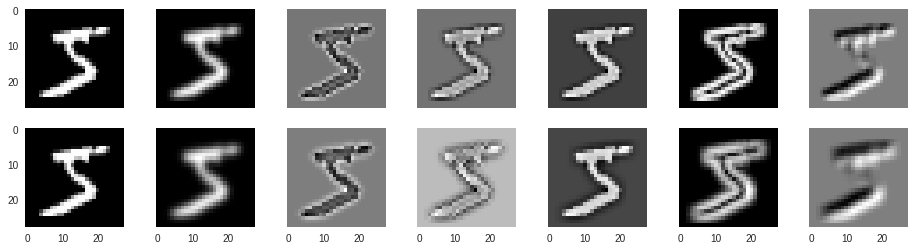

In [6]:
def show_examples(data):
    """
    Plots example images.

    Parameters
    ----------
    data : np.array[grid_width, grid_height, image_width, image_height]
        the image dataset
    """
    height = data.shape[0]
    width = data.shape[1]
    figure, axes = plt.subplots(height, width, figsize=(16, 4), sharex=True, sharey=True)
    
    for h in range(height):
        for w in range(width):
            axis = axes[h][w]
            axis.grid(False)
            axis.imshow(data[h, w, :, :], cmap='gist_gray')
    plt.show()

    
filtered_images = np.array([
    [data[0], gauss_filter,     laplacian_filter,     high_pass_filter,     sharpen,     sobel,     emboss_filter],
    [data[0], gauss_filter_5x5, laplacian_filter_5x5, high_pass_filter_5x5, sharpen_5x5, sobel_5x5, emboss_filter_5x5]
])
show_examples(filtered_images)

### Digit Recognition

To determine which of these filters is beneficial for a classification task and which particular weights to use is a manual and very labor intensive task. Therefore, the idea of a CNN is to determines these weights automatically. Analogous to the fully-connected neural network, this is done through optimization of a loss function.

In [23]:
def preprocess_data(data, labels):
    """
    Flattens the each image in the data to be a one-dimensional feature vector and encodes the labels in one-hot encoding.

    Parameters
    ----------
    data : np.array[samples, width, height]
        the image dataset
    labels : np.array[samples]
        the corresponding labels

    Returns
    -------
    data_and_labels : tuple(np.array[samples, width * height], np.array[samples, classes])
        a tuple with two numpy array containing the flattened data and one-hot encoded labels
    """
    ##############
    return the flattened images and labels
##############

preprocessed_data, preprocessed_labels = preprocess_data(data, labels)

In practice, several convolutional layers with multiple filters each, are applied directly to the image. Hence, a convolutional layers produces multiple image as output, where the number of filters in the layers corresponds to the number of produced images, also often refered to as "color" channels. Convolutions by themselves will slightly reduce the size of the image, as you require a number of "frame" pixels around the convolution (half the convolution filter size, floored). To counteract this effect, an image may be padded with additional pixels, e.g. a constant value like 0 or 1, or by repeating the border pixels (padding='same').

Another way is to use pooling layers (e.g. $\texttt{MaxPooling2D}$) to deliberately combine several outputs of a previous layer to a single input for the next one. In case of a MaxPooling layer with a kernel size of $2\times 2$ pixel and a stride of $2\times 2$ for example, all non-overlapping $2\times 2$ pixel sub-images are reduced to their contained maximum value. The amount of pixels in the output is reduced to a quarter.

Any activation function that is aplicable for a dense layer works for also for a convolutional one. In recent year, however, the community has introduced a number of new activation functions that are a) faster to compute and b) do not suffer as heavily from the vanishing gradient problem, like the sigmoid function does. One of the is the *Recitified Linear Unit (ReLU)*, defined as: $$f(x) = max(x, 0)$$

For classification tasks on images, like digit recognition, a final dense layer is still needed to do the actual classification of the previously filtered image, similar to fully-connected neural network.

Build an image classification model, that takes the correct input shape from the data and passes it through some convolutional, pooling and finally a dense layer and outputs the probability of the image belonging to each class.

Train and test the model.

In [7]:
def build_model(data, classes):
    """
    Constructs a convolutional neural network model for the given data and number of classes

    Parameters
    ----------
    data : np.array[samples, width * height]
        the image dataset
    classes : int
        the number of unique classes in the dataset

    Returns
    -------
    model : keras.Model
        the fully-connected neural network
    """
    model = Sequential()
    
    ##############
    add all the layers
    compile the model with sgd optimizer, categorical crossentropy loss and accuracy printing
    ##############
    
    return model

model = build_model(preprocessed_data, classes=preprocessed_labels.shape[1])

NameError: name 'preprocessed_data' is not defined

In [8]:
class TrainingHistory(Callback):
    """
    Class for tracking the training progress/history of the neural network. Implements the keras.Callback interface.
    """
    def on_train_begin(self, logs):
        self.loss = []
        self.acc = []
        self.validation_loss = []
        self.validation_acc = []
        
    def on_batch_end(self, _, logs):
        """
        Callback invoked after each training batch.
        Should track the training loss and accuracy in the respective members.

        Parameters
        ----------
        _ : int
            unused, int corresponding to the batch number
        logs : dict{str -> float}
            a dictionary mapping from the observed quantity to the actual valu
        """
        if 'loss' in logs:
            self.loss.append(logs['loss'])
        if 'acc' in logs:
            self.acc.append(logs['acc'])
            
    def on_epoch_end(self, _, logs):
        if 'val_loss' in logs:
            self.validation_loss.append(logs['val_loss'])
        if 'val_acc' in logs:
            self.validation_acc.append(logs['val_acc'])

In [29]:
def train_model(model, data, labels, epochs=25, batch_size=64, train_fraction=0.8):
    """
    Trains a convolutional neural network given the data and labels.
    This time we employ the automatic train and test set functionality of Keras.

    Parameters
    ----------
    model : keras.Model
        the fully-connected neural network
    data : np.array[samples, width * height]
        the entire data
    labels : np.array[samples, classes]
        the one-hot encoded training labels
    epoch: positive int, optional
        the number of epochs for which the neural network is trained, defaults to 50
    batch_size: positive int, optional
        the size of the training batches, defaults to 64
    train_fraction: positive float, optional
        the fraction of data to be used as training data, defaults to 0.8

    Returns
    -------
    history : TrainingHistory
        the tracked training and test history
    """
    history = TrainingHistory()
    model.fit(
        data, 
        labels, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_split=1.0 - train_fraction, 
        shuffle=True,
        callbacks=[history]
    )
    return history
    
history = train_model(model, preprocessed_data, preprocessed_labels)

Train on 56000 samples, validate on 14000 samples
Epoch 1/30
56000/56000 [==============================] - 139s 2ms/step - loss: 0.6056 - acc: 0.8268 - val_loss: 0.1991 - val_acc: 0.9422
Epoch 2/30
56000/56000 [==============================] - 142s 3ms/step - loss: 0.2139 - acc: 0.9354 - val_loss: 0.1296 - val_acc: 0.9617
Epoch 3/30
56000/56000 [==============================] - 142s 3ms/step - loss: 0.1570 - acc: 0.9525 - val_loss: 0.1040 - val_acc: 0.9682
Epoch 4/30
56000/56000 [==============================] - 145s 3ms/step - loss: 0.1254 - acc: 0.9616 - val_loss: 0.0857 - val_acc: 0.9749
Epoch 5/30
56000/56000 [==============================] - 144s 3ms/step - loss: 0.1076 - acc: 0.9671 - val_loss: 0.0771 - val_acc: 0.9756
Epoch 6/30
56000/56000 [==============================] - 152s 3ms/step - loss: 0.0922 - acc: 0.9721 - val_loss: 0.0682 - val_acc: 0.9801
Epoch 7/30
56000/56000 [==============================] - 145s 3ms/step - loss: 0.0817 - acc: 0.9751 - val_loss: 0.0616 - 

### Visualization of the Training Progress

Using the previously created and filled TrainingHistory instance, we are able to plot the loss and accuracy of the training batches and test epochs.

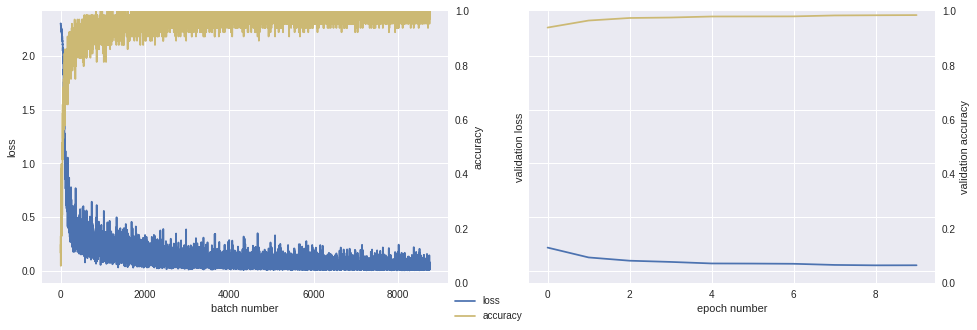

In [16]:
def plot_history(history):
    """
    Plots the training (batch-wise) and test (epoch-wise) loss and accuracy.

    Parameters
    ----------
    history : TrainingHistory
        an instance of TrainingHistory monitoring callback
    """
    figure, (batch_axis, epoch_axis) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
    
    # plot the training loss and accuracy
    batch_axis.set_xlabel('batch number')
    training_batches = np.arange(len(history.loss))
    
    batch_axis.plot(training_batches, history.loss, color='C0', label='loss')
    batch_axis.set_ylabel('loss')
    
    batch_acc_axis = batch_axis.twinx()
    batch_acc_axis.grid(False)
    batch_acc_axis.set_ylabel('accuracy')
    batch_acc_axis.set_ylim(bottom=0.0)
    batch_acc_axis.plot(training_batches, history.acc, color='C4', label='accuracy')
    
    # plot the training loss and accuracy
    epoch_axis.set_xlabel('epoch number')
    validation_epochs = np.arange(len(history.validation_loss))
    
    epoch_axis.plot(validation_epochs, history.validation_loss, color='C0')
    epoch_axis.set_ylabel('validation loss')
    
    epoch_acc_axis = epoch_axis.twinx()
    epoch_acc_axis.grid(False)
    epoch_acc_axis.set_ylabel('validation accuracy')
    epoch_acc_axis.set_ylim(bottom=0.0)
    epoch_acc_axis.plot(validation_epochs, history.validation_acc, color='C4')
    
    # display a legend
    figure.legend(loc=8)
    plt.show()

plot_history(history)

Next: add $\texttt{Dropout}$ layers and observe their effect on the history.
\emph{Dropout} is a technique to reduce overfitting to the training data by randomly selecting neurons and setting their activation to $0$.
The $\texttt{Dropout}$ layer in Keras just passes through its input, except in randomly selected positions, where it passes through $0$.

### Your Convolutions

Extract the learned filters from CNN and apply them to the image. Try to compare them with the previously introduced example filters.

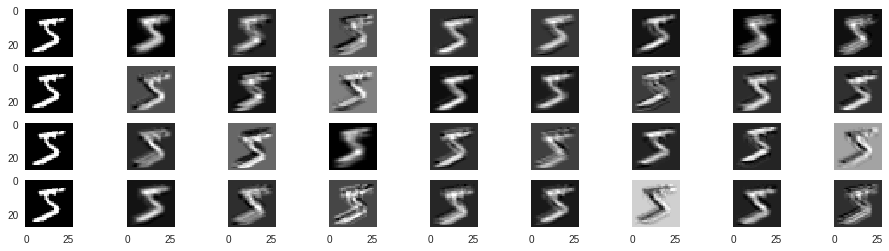

In [13]:
def apply_network_convolutions(image, weights):
    """
    Applies the passed convolutional weights to the image.

    Parameters
    ----------
    image : np.array[width, height]
        the image to be filtered
    weights : np.array[filters, filter_width, filter_height]
        the convolutional filter weights

    Returns
    -------
    filtered images : np.array[filters, width, height]
        the filtered images
    """
    height, width = image.shape
    kernels_y, kernels_x = weights.shape[:2]
    
    output = np.zeros((kernels_y, kernels_x + 1, height, width), dtype=image.dtype)
    ##############
    apply the convolutions to the image and store the output in output
    ##############
    return output

weights = np.moveaxis(model.get_weights()[0], 0, -1).reshape(4, 8, 5, 5)
model_convolutions = apply_network_convolutions(data[0], weights)
show_examples(model_convolutions)

Activate the filtered images additionally with ReLU function.

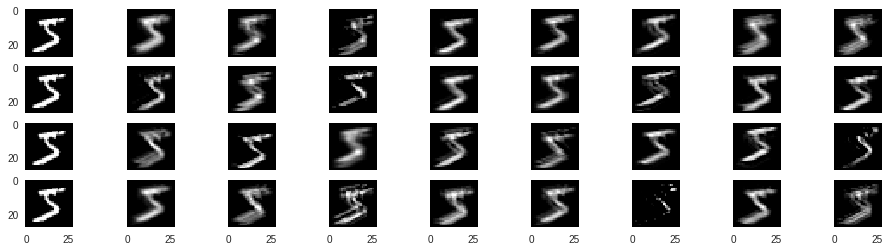

In [14]:
activated = model_convolutions.copy()
activated[activated < 0] = 0
show_examples(activated)

### Bonus:
Add a [naive inception layer](https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf) to your CNN and investigate its effect.
Simplified, an inception layer are multiple convolutional layers with different filter sizes in parallel that are supposed to 'look' at the image on different resolution levels.

In order to be able to implement this network, you will need advanced features of the Keras library, like the [functional API](https://keras.io/getting-started/functional-api-guide/), which allows you to specify layer connections, and the $\texttt{Input}$ and $\texttt{Model}$ classes.